# Projeto - Motor de Recomendação

Este projeto apresenta o desenvolvimento de um sistema de recomendação híbrido para e-commerce, cobrindo todo o ciclo de vida de uma solução de Machine Learning aplicada em contexto real de negócio.

O objetivo central é aumentar conversão e ticket médio por meio de recomendações personalizadas, utilizando múltiplos sinais complementares:

* comportamento histórico de compra (Collaborative Filtering),
* similaridade semântica entre produtos (Content-Based),
* padrões explícitos de coocorrência em cestas de compra (Association Rules). 

## EDA - Exploratory Data Analysis

In [1]:
from getpass import getpass
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import random
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import pickle
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# Conectar no SQL
DB_USER = "root"
DB_HOST = "127.0.0.1"
DB_PORT = 3306
DB_NAME = "ecommerce_db"
DB_PASS = getpass("DB password: ")

CONN_STR = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(CONN_STR, echo=False)

DB password:  ········


In [3]:
def run_sql_pure(sql: str, params: dict = None):
    """
    Executa SQL puro (string) e retorna um pandas.DataFrame.
    Exibe a query e retorna o DataFrame.
    """
    print("---- Executing SQL ----")
    print(sql.strip())
    print("-----------------------")
    df = pd.read_sql_query(sql=text(sql), con=engine, params=params)
    display(df.head(10))
    return df

# Configuração do matplotlib
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['grid.linestyle'] = '--'

Contagens por tabela

In [4]:
sql = """
SELECT 
  (SELECT COUNT(*) FROM customers) AS n_customers,
  (SELECT COUNT(*) FROM products)  AS n_products,
  (SELECT COUNT(*) FROM transactions) AS n_transactions,
  (SELECT COUNT(*) FROM product_views) AS n_views;
"""
df = run_sql_pure(sql)
vals = df.iloc[0].to_dict()
names = list(vals.keys()); counts = list(vals.values())


---- Executing SQL ----
SELECT 
  (SELECT COUNT(*) FROM customers) AS n_customers,
  (SELECT COUNT(*) FROM products)  AS n_products,
  (SELECT COUNT(*) FROM transactions) AS n_transactions,
  (SELECT COUNT(*) FROM product_views) AS n_views;
-----------------------


,n_customers,n_products,n_transactions,n_views
0,1000,300,21123,70000


Checar valores ausentes por tabela

In [5]:
# lista de tabelas a verificar
tables = ['customers', 'products', 'transactions', 'product_views']

results = []
for t in tables:
    q_cols = f"""
    SELECT COLUMN_NAME
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE TABLE_SCHEMA = '{DB_NAME}'
      AND TABLE_NAME = '{t}'
    ORDER BY ORDINAL_POSITION;
    """
    cols_df = pd.read_sql_query(sql=text(q_cols), con=engine)
    cols = cols_df['COLUMN_NAME'].tolist()
    num_cols = len(cols)

    # contar linhas
    q_rows = f"SELECT COUNT(*) AS n_rows FROM {t};"
    n_rows = pd.read_sql_query(sql=text(q_rows), con=engine).iloc[0,0]

    if n_rows == 0 or num_cols == 0:
        null_count = 0
    else:
        null_expr = " + ".join([f"SUM(`{c}` IS NULL)" for c in cols])
        q_nulls = f"SELECT {null_expr} AS null_count FROM {t};"
        null_count = pd.read_sql_query(sql=text(q_nulls), con=engine).iloc[0,0]

    total_cells = int(n_rows) * int(num_cols)
    pct_null = (null_count / total_cells * 100) if total_cells > 0 else 0.0

    results.append({
        "table": t,
        "n_rows": int(n_rows),
        "n_cols": int(num_cols),
        "total_cells": int(total_cells),
        "null_count": int(null_count),
        "pct_null": round(pct_null, 4)
    })

df_missing_tables = pd.DataFrame(results)
display(df_missing_tables)

,table,n_rows,n_cols,total_cells,null_count,pct_null
0,customers,1000,8,8000,0,0.0
1,products,300,7,2100,0,0.0
2,transactions,21123,6,126738,0,0.0
3,product_views,70000,6,420000,0,0.0


Duplicados e chaves (checar chave primária única)

In [6]:
sql = """
SELECT 
  COUNT(*) AS total_rows,
  COUNT(DISTINCT transaction_id) AS distinct_transaction_id,
  COUNT(DISTINCT CONCAT(customer_id,'-',DATE(transaction_date))) AS distinct_cust_date
FROM transactions;
"""
df = run_sql_pure(sql)
print(df.to_string(index=False))

---- Executing SQL ----
SELECT 
  COUNT(*) AS total_rows,
  COUNT(DISTINCT transaction_id) AS distinct_transaction_id,
  COUNT(DISTINCT CONCAT(customer_id,'-',DATE(transaction_date))) AS distinct_cust_date
FROM transactions;
-----------------------


,total_rows,distinct_transaction_id,distinct_cust_date
0,21123,21123,11804


 total_rows  distinct_transaction_id  distinct_cust_date
      21123                    21123               11804


**Distribuição de preços — produtos (histograma)**

---- Executing SQL ----
SELECT price FROM products WHERE price IS NOT NULL;
-----------------------


,price
0,1348.64
1,1231.56
2,442.11
3,1459.57
4,471.71
5,426.05
6,306.27
7,1119.19
8,1236.90
9,126.46


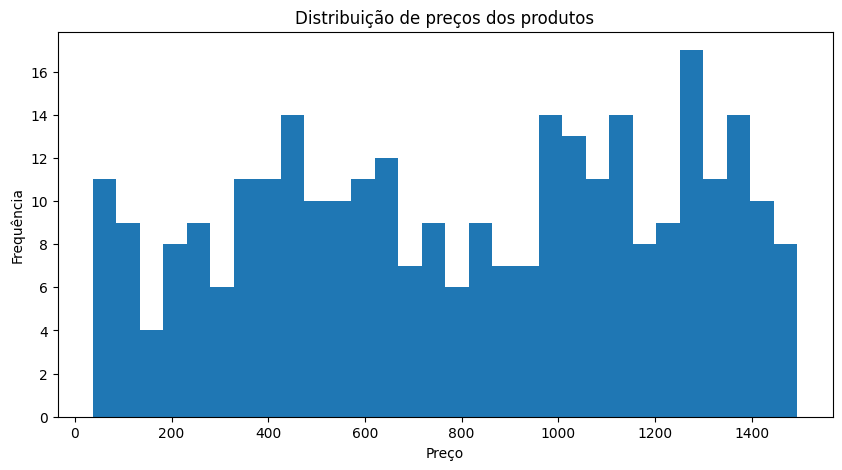

In [7]:
sql = "SELECT price FROM products WHERE price IS NOT NULL;"
df_price = run_sql_pure(sql)
# converter coluna price se necessário
df_price['price'] = pd.to_numeric(df_price['price'], errors='coerce')
plt.hist(df_price['price'].dropna(), bins=30)
plt.title("Distribuição de preços dos produtos")
plt.xlabel("Preço")
plt.ylabel("Frequência")
plt.show()

Top produtos por quantidade e por receita

---- Executing SQL ----
SELECT p.product_id, p.name,
       SUM(t.quantity) AS total_qty,
       SUM(t.total_value) AS total_revenue
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.product_id
ORDER BY total_qty DESC
LIMIT 15;
-----------------------


,product_id,name,total_qty,total_revenue
0,251,Acessórios Oakley Eos,217.0,186915.12
1,192,Acessórios Rayban Molestiae,211.0,108861.23
2,82,Acessórios Rayban Iure,205.0,185129.35
3,95,Acessórios Oakley Repellat,205.0,18025.65
4,177,Acessórios Oakley Quo,195.0,221867.10
5,161,Acessórios Samsung Earum,193.0,279170.64
6,235,Acessórios Rayban Ullam,185.0,156080.80
7,169,Acessórios Rayban Repudiandae,184.0,211294.56
8,211,Acessórios Oakley Iste,183.0,91657.38
9,49,Acessórios Rayban Harum,182.0,64921.22


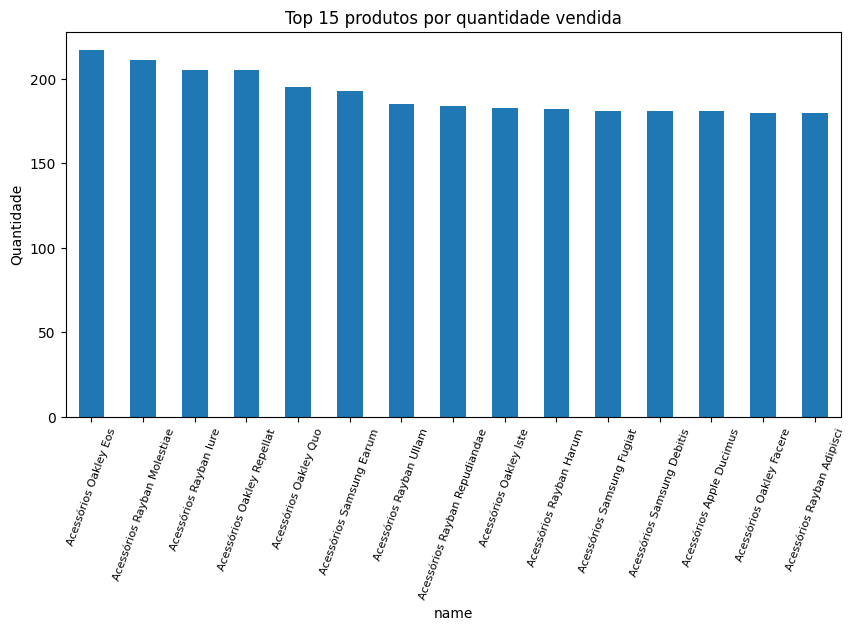

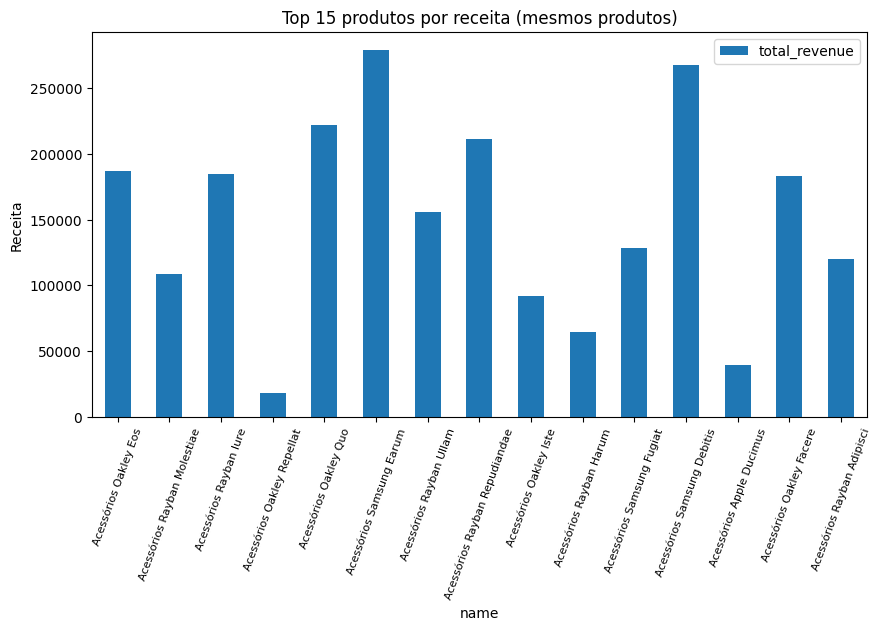

In [8]:
sql = """
SELECT p.product_id, p.name,
       SUM(t.quantity) AS total_qty,
       SUM(t.total_value) AS total_revenue
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.product_id
ORDER BY total_qty DESC
LIMIT 15;
"""
df_top = run_sql_pure(sql)
ax = df_top.plot.bar(x='name', y='total_qty', legend=False)
plt.xticks(rotation=70, fontsize=8)
plt.title("Top 15 produtos por quantidade vendida")
plt.ylabel("Quantidade")
plt.show()

# revenue bar
df_top.plot.bar(x='name', y='total_revenue')
plt.xticks(rotation=70, fontsize=8)
plt.title("Top 15 produtos por receita (mesmos produtos)")
plt.ylabel("Receita")
plt.show()

Vendas por mês

---- Executing SQL ----
SELECT DATE_FORMAT(transaction_date, '%Y-%m') AS ym,
       COUNT(*) AS n_items,
       SUM(total_value) AS revenue
FROM transactions
GROUP BY ym
ORDER BY ym;
-----------------------


,ym,n_items,revenue
0,2024-12,965,1078916.67
1,2025-01,1828,2176511.82
2,2025-02,1612,1812512.41
3,2025-03,1741,2033208.48
4,2025-04,1806,2085717.98
5,2025-05,1749,2003141.91
6,2025-06,1675,1968112.97
7,2025-07,1915,2197290.58
8,2025-08,1861,2203234.08
9,2025-09,1632,1932849.30


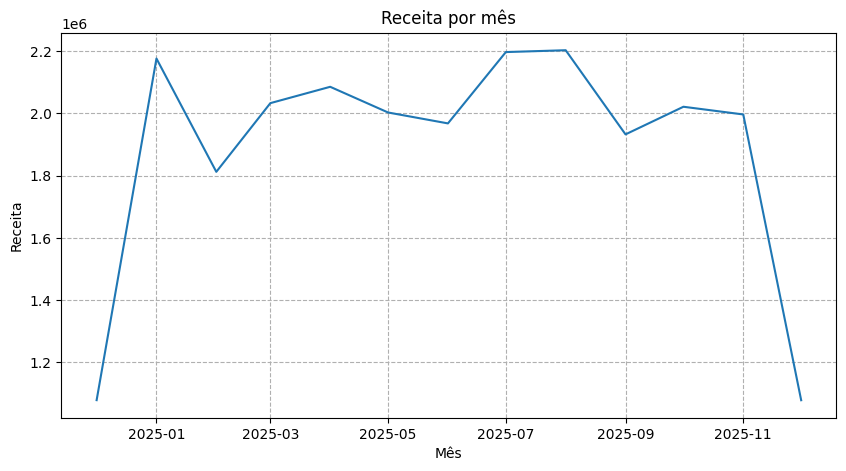

In [9]:
sql = """
SELECT DATE_FORMAT(transaction_date, '%Y-%m') AS ym,
       COUNT(*) AS n_items,
       SUM(total_value) AS revenue
FROM transactions
GROUP BY ym
ORDER BY ym;
"""
df_ts = run_sql_pure(sql)
df_ts['ym'] = pd.to_datetime(df_ts['ym'] + '-01')
plt.plot(df_ts['ym'], df_ts['revenue'])
plt.title("Receita por mês")
plt.xlabel("Mês")
plt.ylabel("Receita")
plt.grid(True)
plt.show()

RFM — tabela e histogramas

---- Executing SQL ----
WITH last AS (
  SELECT customer_id,
         DATEDIFF(CURDATE(), MAX(DATE(transaction_date))) AS recency_days,
         COUNT(*) AS frequency,
         SUM(total_value) AS monetary
  FROM transactions
  GROUP BY customer_id
)
SELECT * FROM last;
-----------------------


,customer_id,recency_days,frequency,monetary
0,1,17,14,14261.37
1,2,21,26,26203.35
2,3,79,23,25696.87
3,4,37,26,31203.42
4,5,130,11,16216.30
5,6,30,29,26575.41
6,7,42,20,21554.50
7,8,41,22,31804.66
8,9,29,21,24763.75
9,10,12,19,18695.84


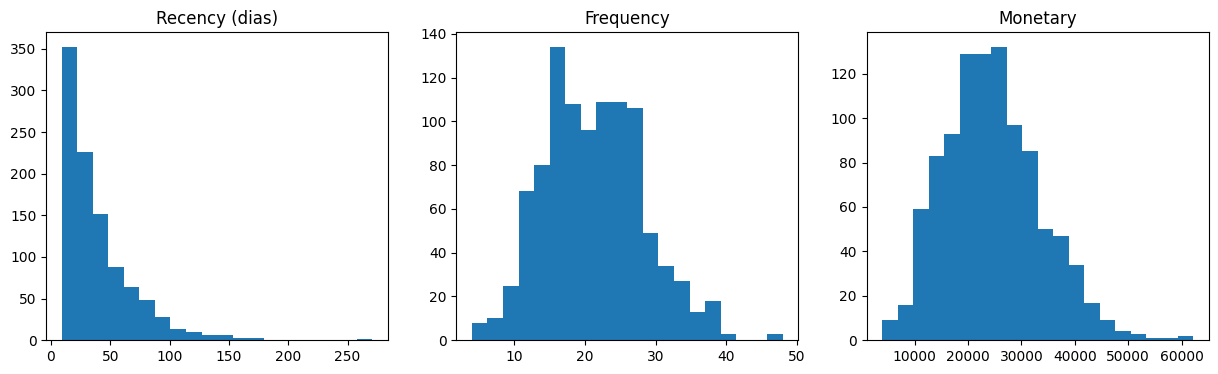

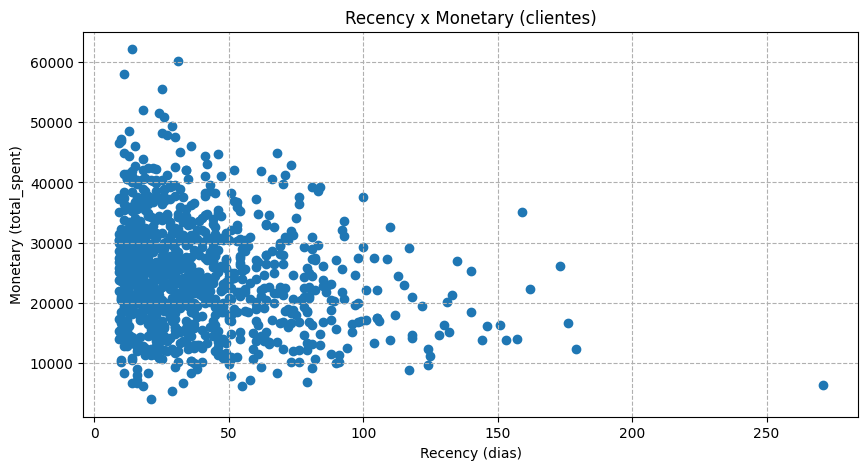

In [10]:
sql = """
WITH last AS (
  SELECT customer_id,
         DATEDIFF(CURDATE(), MAX(DATE(transaction_date))) AS recency_days,
         COUNT(*) AS frequency,
         SUM(total_value) AS monetary
  FROM transactions
  GROUP BY customer_id
)
SELECT * FROM last;
"""
df_rfm = run_sql_pure(sql)
# Histograms
fig, axes = plt.subplots(1,3, figsize=(15,4))
axes[0].hist(df_rfm['recency_days'].dropna(), bins=20); axes[0].set_title('Recency (dias)')
axes[1].hist(df_rfm['frequency'].dropna(), bins=20); axes[1].set_title('Frequency')
axes[2].hist(df_rfm['monetary'].dropna(), bins=20); axes[2].set_title('Monetary')
plt.show()

# scatter recency x monetary
plt.scatter(df_rfm['recency_days'], df_rfm['monetary'])
plt.xlabel('Recency (dias)'); plt.ylabel('Monetary (total_spent)')
plt.title('Recency x Monetary (clientes)')
plt.grid(True)
plt.show()

Distribuição de compras por cliente

---- Executing SQL ----
SELECT customer_id, COUNT(*) AS purchases
FROM transactions
GROUP BY customer_id;
-----------------------


,customer_id,purchases
0,1,14
1,2,26
2,3,23
3,4,26
4,5,11
5,6,29
6,7,20
7,8,22
8,9,21
9,10,19


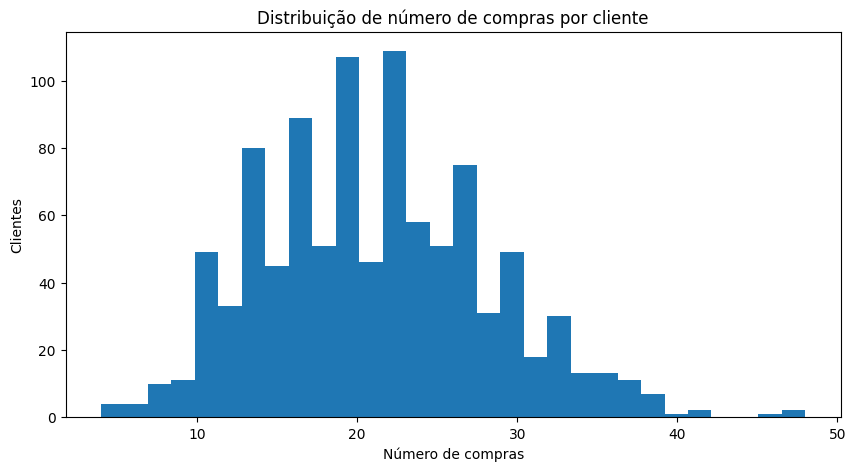

In [11]:
sql = """
SELECT customer_id, COUNT(*) AS purchases
FROM transactions
GROUP BY customer_id;
"""
df_purchases = run_sql_pure(sql)
plt.hist(df_purchases['purchases'], bins=30)
plt.title("Distribuição de número de compras por cliente")
plt.xlabel("Número de compras")
plt.ylabel("Clientes")
plt.show()

Conversão views -> buys por produto

---- Executing SQL ----
SELECT p.product_id, p.name,
  COALESCE(v.views,0) AS views,
  COALESCE(b.buys,0)  AS buys,
  ROUND(COALESCE(b.buys,0) / NULLIF(COALESCE(v.views,0),0) * 100,2) AS conversion_pct
FROM products p
LEFT JOIN (
  SELECT product_id, COUNT(*) AS views
  FROM product_views
  GROUP BY product_id
) v ON p.product_id = v.product_id
LEFT JOIN (
  SELECT product_id, COUNT(*) AS buys
  FROM transactions
  GROUP BY product_id
) b ON p.product_id = b.product_id;
-----------------------


,product_id,name,views,buys,conversion_pct
0,1,Eletrônicos LG Repellendus,254,67,26.38
1,2,Roupas Puma Ad,199,50,25.13
2,3,Acessórios Apple Assumenda,262,120,45.80
3,4,Eletrônicos Apple Fugit,269,61,22.68
4,5,Calçados Adidas Nisi,197,51,25.89
5,6,Eletrônicos LG Architecto,237,48,20.25
6,7,Eletrônicos Apple Magni,254,60,23.62
7,8,Calçados Mizuno Vero,251,54,21.51
8,9,Casa Brastemp Accusamus,211,60,28.44
9,10,Casa Tramontina Aut,208,69,33.17


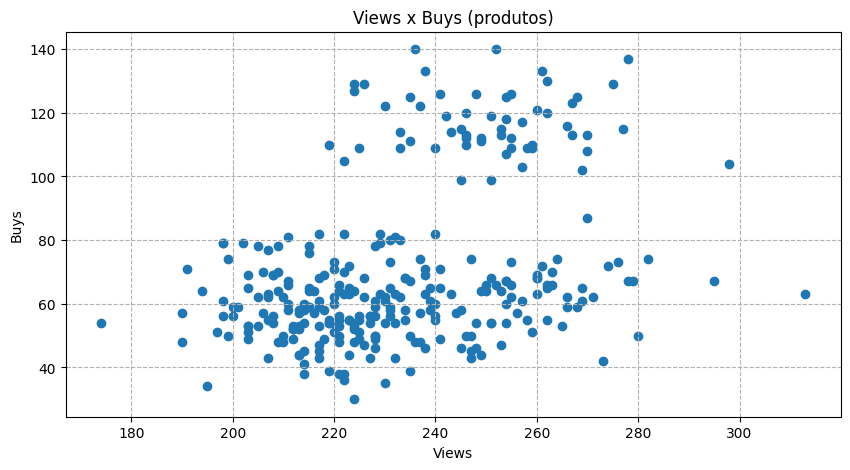

Produtos com conversão > 80% (exemplo):


,product_id,name,views,buys,conversion_pct


In [12]:
sql = """
SELECT p.product_id, p.name,
  COALESCE(v.views,0) AS views,
  COALESCE(b.buys,0)  AS buys,
  ROUND(COALESCE(b.buys,0) / NULLIF(COALESCE(v.views,0),0) * 100,2) AS conversion_pct
FROM products p
LEFT JOIN (
  SELECT product_id, COUNT(*) AS views
  FROM product_views
  GROUP BY product_id
) v ON p.product_id = v.product_id
LEFT JOIN (
  SELECT product_id, COUNT(*) AS buys
  FROM transactions
  GROUP BY product_id
) b ON p.product_id = b.product_id;
"""
df_conv = run_sql_pure(sql)
plt.scatter(df_conv['views'], df_conv['buys'])
plt.xlabel('Views'); plt.ylabel('Buys')
plt.title('Views x Buys (produtos)')
plt.grid(True)
plt.show()

# print top products with unusually high conversion (>80%)
high_conv = df_conv[df_conv['conversion_pct'] > 80].sort_values('conversion_pct', ascending=False)
print("Produtos com conversão > 80% (exemplo):")
display(high_conv[['product_id','name','views','buys','conversion_pct']].head(10))

Vendas por categoria

---- Executing SQL ----
SELECT p.category, COUNT(*) AS n_items, SUM(t.total_value) AS revenue
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.category
ORDER BY revenue DESC;
-----------------------


,category,n_items,revenue
0,Acessórios,6791,8093968.03
1,Casa,4201,4853473.99
2,Roupas,3493,4130537.90
3,Eletrônicos,3393,3875183.58
4,Calçados,3245,3635461.14


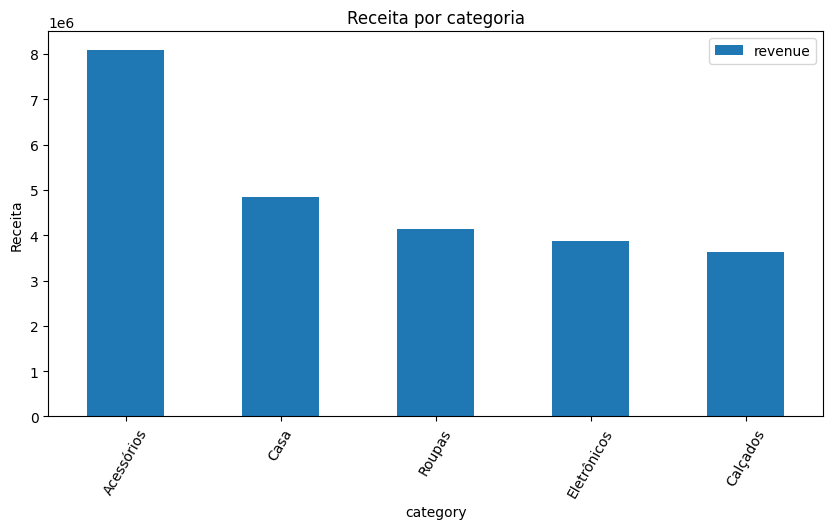

In [13]:
sql = """
SELECT p.category, COUNT(*) AS n_items, SUM(t.total_value) AS revenue
FROM transactions t
JOIN products p ON t.product_id = p.product_id
GROUP BY p.category
ORDER BY revenue DESC;
"""
df_cat = run_sql_pure(sql)
df_cat.plot.bar(x='category', y='revenue')
plt.title("Receita por categoria")
plt.xticks(rotation=60)
plt.ylabel("Receita")
plt.show()

AOV (Average Order Value)

---- Executing SQL ----
SELECT customer_id, DATE(transaction_date) AS order_date, SUM(total_value) AS order_value
FROM transactions
GROUP BY customer_id, DATE(transaction_date);
-----------------------


,customer_id,order_date,order_value
0,847,2025-10-23,590.62
1,61,2025-03-13,1701.93
2,859,2025-03-20,6656.51
3,162,2025-02-09,3413.34
4,690,2025-09-10,715.62
5,938,2025-10-22,2335.58
6,457,2025-10-27,2188.03
7,152,2025-08-30,3409.31
8,757,2025-09-10,511.88
9,64,2025-01-08,717.88


AOV (média de valor por pedido - aproximação): R$ 2083.08


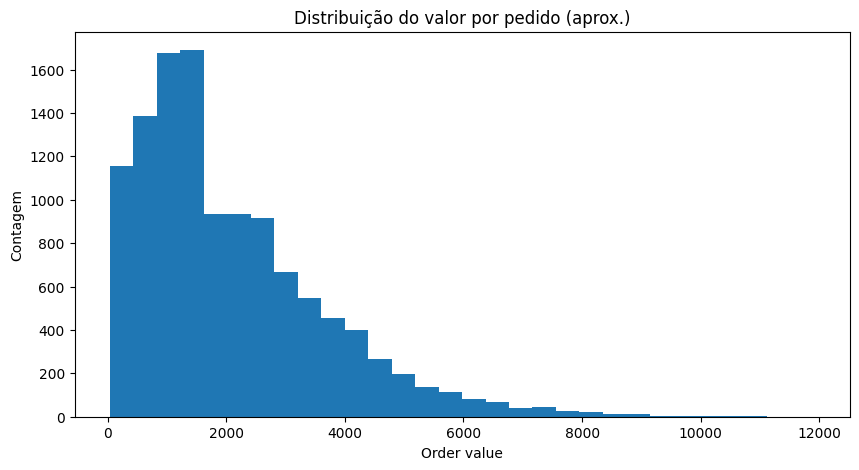

In [14]:
sql = """
SELECT customer_id, DATE(transaction_date) AS order_date, SUM(total_value) AS order_value
FROM transactions
GROUP BY customer_id, DATE(transaction_date);
"""
df_orders = run_sql_pure(sql)
aov = df_orders['order_value'].mean()
print(f"AOV (média de valor por pedido - aproximação): R$ {aov:.2f}")
plt.hist(df_orders['order_value'], bins=30)
plt.title("Distribuição do valor por pedido (aprox.)")
plt.xlabel("Order value")
plt.ylabel("Contagem")
plt.show()


Matriz cliente×produto densidade (sparsity)

In [15]:
sql = """
SELECT (SELECT COUNT(DISTINCT customer_id) FROM transactions) AS n_customers_active,
       (SELECT COUNT(DISTINCT product_id) FROM transactions) AS n_products_sold,
       (SELECT COUNT(*) FROM transactions) AS n_transactions;
"""
df_dim = run_sql_pure(sql)
n_customers = int(df_dim['n_customers_active'].iloc[0])
n_products = int(df_dim['n_products_sold'].iloc[0])
n_trans = int(df_dim['n_transactions'].iloc[0])
possible = n_customers * n_products
sparsity = 1 - (n_trans / possible)
print(f"Clientes: {n_customers}, Produtos: {n_products}, Transações: {n_trans}")
print(f"Sparsity (aprox): {sparsity:.6f}")

---- Executing SQL ----
SELECT (SELECT COUNT(DISTINCT customer_id) FROM transactions) AS n_customers_active,
       (SELECT COUNT(DISTINCT product_id) FROM transactions) AS n_products_sold,
       (SELECT COUNT(*) FROM transactions) AS n_transactions;
-----------------------


,n_customers_active,n_products_sold,n_transactions
0,1000,300,21123


Clientes: 1000, Produtos: 300, Transações: 21123
Sparsity (aprox): 0.929590


## Insights

A análise revela padrões importantes:

* alta concentração de vendas em poucas categorias,
* clientes com frequência relativamente elevada,
* sparsity alta (>90%) na matriz de interações.

Os padrões observados suportam a construção de um sistema de recomendação híbrido, combinando similaridade entre itens, regras de coocorrência, conteúdo dos produtos e segmentação de clientes.

# Criação dos Algoritimos

In [16]:
## Item-Item Collaborative Filtering

In [17]:
# Carregando datasets
DATA_PATH = "data/"

customers = pd.read_csv(f"{DATA_PATH}customers.csv")
products = pd.read_csv(f"{DATA_PATH}products.csv")
transactions = pd.read_csv(f"{DATA_PATH}transactions.csv")
views = pd.read_csv(f"{DATA_PATH}product_views.csv")

transactions.head()

,transaction_id,customer_id,product_id,quantity,total_value,transaction_date
0,1,847,207,1,590.62,2025-10-23 03:41:24.694093
1,2,61,295,1,873.03,2025-03-13 18:30:47.694093
2,3,61,265,1,828.90,2025-03-13 18:30:47.694093
3,4,859,93,2,2504.60,2025-03-20 09:13:00.694093
4,5,859,256,1,710.39,2025-03-20 09:13:00.694093


In [18]:
# Criar dataset de interações (cliente × produto)
interactions = (
    transactions[['customer_id', 'product_id']]
    .drop_duplicates()
)

interactions['interaction'] = 1
interactions.head()

,customer_id,product_id,interaction
0,847,207,1
1,61,295,1
2,61,265,1
3,859,93,1
4,859,256,1


In [19]:
# Construir a matriz Item × Cliente
item_user_matrix = interactions.pivot_table(
    index='product_id',
    columns='customer_id',
    values='interaction',
    fill_value=0
)

item_user_matrix.shape

(300, 1000)

In [20]:
# Checar Sparsity
density = item_user_matrix.values.sum() / item_user_matrix.size
sparsity = 1 - density

print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.9333


In [21]:
# Calcular Similaridade Item-Item (Cosine)
item_similarity = cosine_similarity(item_user_matrix)

item_sim_df = pd.DataFrame(
    item_similarity,
    index=item_user_matrix.index,
    columns=item_user_matrix.index
)

item_sim_df.iloc[:5, :5]

product_id,1,2,3,4,5
product_id,,,,,
1,1.000000,0.053995,0.096540,0.066172,0.054554
2,0.053995,1.000000,0.068416,0.112548,0.041239
3,0.096540,0.068416,1.000000,0.088038,0.082950
4,0.066172,0.112548,0.088038,1.000000,0.000000
5,0.054554,0.041239,0.082950,0.000000,1.000000


In [22]:
# Co-ocorrencia
cooccurrence = item_user_matrix @ item_user_matrix.T

In [23]:
# Shrinkage
LAMBDA = 10
shrunk_similarity = item_sim_df * (cooccurrence / (cooccurrence + LAMBDA))

In [24]:
# Função de Recomendação (Item-Item CF)
def recommend_item_item(user_id, k=10):
    # Produtos comprados pelo usuário
    bought_items = interactions.loc[
        interactions['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return pd.Series(dtype=float)

    # Score médio de similaridade
    scores = shrunk_similarity.loc[bought_items].mean(axis=0)

    # Remover itens já comprados
    scores = scores.drop(bought_items, errors='ignore')

    return scores.sort_values(ascending=False).head(k)

In [25]:
# Teste do modelo
test_user = interactions['customer_id'].iloc[0]
recommend_item_item(test_user, k=5)

product_id
226    0.049454
115    0.049118
240    0.048700
177    0.048648
251    0.048641
dtype: float64

In [26]:
# Enriquecer com informações do produto
def recommend_with_metadata(user_id, k=10):
    recs = recommend_item_item(user_id, k)
    
    return (
        recs
        .reset_index()
        .merge(products, on='product_id', how='left')
        .rename(columns={0: 'score'})
    )

recommend_with_metadata(test_user, k=5)

,product_id,score,name,category,brand,price,created_at,is_active
0,226,0.049454,Casa Tramontina Aliquam,Casa,Tramontina,1060.30,2025-04-24 19:35:33,1
1,115,0.049118,Casa Brastemp Consequuntur,Casa,Brastemp,1209.33,2025-09-24 12:32:13,1
2,240,0.048700,Casa Tramontina Non,Casa,Tramontina,266.60,2025-04-09 07:52:33,1
3,177,0.048648,Acessórios Oakley Quo,Acessórios,Oakley,1137.78,2025-06-19 00:19:11,1
4,251,0.048641,Acessórios Oakley Eos,Acessórios,Oakley,861.36,2025-10-01 13:00:22,1


## Content-Based FIltering

In [27]:
# Preparação do texto dos produtos
products_cb = products.copy()

products_cb['text'] = (
    products_cb['name'].fillna('') + ' ' +
    products_cb['category'].fillna('') + ' ' +
    products_cb['brand'].fillna('')
)

products_cb[['product_id', 'text']].head()

,product_id,text
0,1,Eletrônicos LG Repellendus Eletrônicos LG
1,2,Roupas Puma Ad Roupas Puma
2,3,Acessórios Apple Assumenda Acessórios Apple
3,4,Eletrônicos Apple Fugit Eletrônicos Apple
4,5,Calçados Adidas Nisi Calçados Adidas


In [28]:
# Vetorização com TF-IDF
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2
)

tfidf_matrix = tfidf.fit_transform(products_cb['text'])

tfidf_matrix.shape

(300, 178)

In [29]:
# Similaridade entre produtos (Cosine)
content_similarity = cosine_similarity(tfidf_matrix)

In [30]:
# Criar matriz Produto × Produto
content_sim_df = pd.DataFrame(
    content_similarity,
    index=products_cb['product_id'],
    columns=products_cb['product_id']
)

content_sim_df.iloc[:5, :5]

product_id,1,2,3,4,5
product_id,,,,,
1,1.000000,0.0,0.000000,0.171325,0.0
2,0.000000,1.0,0.000000,0.000000,0.0
3,0.000000,0.0,1.000000,0.279115,0.0
4,0.171325,0.0,0.279115,1.000000,0.0
5,0.000000,0.0,0.000000,0.000000,1.0


In [31]:
# Função de recomendação Content-Based
def recommend_content_based(user_id, k=10):
    bought_items = interactions.loc[
        interactions['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return pd.Series(dtype=float)

    scores = content_sim_df.loc[bought_items].mean(axis=0)
    scores = scores.drop(bought_items, errors='ignore')

    return scores.sort_values(ascending=False).head(k)

In [32]:
# Teste do Content-Based
test_user = interactions['customer_id'].iloc[0]
recommend_content_based(test_user, k=5)

product_id
273    0.261552
48     0.261552
236    0.261552
153    0.261552
198    0.238911
dtype: float64

In [33]:
# Enriquecer com metadata
def recommend_cb_with_metadata(user_id, k=10):
    recs = recommend_content_based(user_id, k)
    return (
        recs
        .reset_index()
        .merge(products, on='product_id', how='left')
        .rename(columns={0: 'score'})
    )

recommend_cb_with_metadata(test_user, k=5)

,product_id,score,name,category,brand,price,created_at,is_active
0,273,0.261552,Casa Tramontina Qui,Casa,Tramontina,685.94,2025-04-16 05:18:13,1
1,48,0.261552,Casa Tramontina Hic,Casa,Tramontina,1421.98,2025-02-23 00:01:48,1
2,236,0.261552,Casa Tramontina Facilis,Casa,Tramontina,211.16,2025-10-03 22:08:43,1
3,153,0.261552,Casa Tramontina Praesentium,Casa,Tramontina,1446.87,2025-06-09 04:19:16,1
4,198,0.238911,Casa Tramontina Quae,Casa,Tramontina,1185.80,2025-11-15 18:44:03,1


## Avaliação CF vs CB antes do modelo Híbrido

In [34]:
interactions_eval = transactions[['customer_id', 'product_id', 'transaction_date']].copy()

# Garantir tipo datetime
interactions_eval['transaction_date'] = pd.to_datetime(
    interactions_eval['transaction_date']
)

# Ordenar temporalmente
interactions_eval = interactions_eval.sort_values(
    ['customer_id', 'transaction_date', 'product_id']
)

# Inicializar estruturas
train_interactions = []
test_interactions = {}

# Holdout temporal (Last Item)
for user_id, group in interactions_eval.groupby('customer_id'):
    items = group['product_id'].tolist()

    if len(items) < 2:
        continue

    test_item = items[-1]  # último item (mais recente)
    test_interactions[user_id] = test_item

    for item in items[:-1]:
        train_interactions.append((user_id, item))

train_df = pd.DataFrame(
    train_interactions,
    columns=['customer_id', 'product_id']
)
train_df['interaction'] = 1


In [35]:
# Recriar matriz Item × User para treino
item_user_train = train_df.pivot_table(
    index='product_id',
    columns='customer_id',
    values='interaction',
    fill_value=0
)

In [36]:
# Rcalcular CF treino
item_sim_train = cosine_similarity(item_user_train)
item_sim_train_df = pd.DataFrame(
    item_sim_train,
    index=item_user_train.index,
    columns=item_user_train.index
)


In [37]:
# Função de recomendação para avaliação (CF)
def recommend_cf_eval(user_id, k=10):
    bought_items = train_df.loc[
        train_df['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return []

    scores = item_sim_train_df.loc[bought_items].mean(axis=0)
    scores = scores.drop(bought_items, errors='ignore')

    return scores.sort_values(ascending=False).head(k).index.tolist()

In [38]:
# Função de recomendação para avaliação
def recommend_cb_eval(user_id, k=10):
    bought_items = train_df.loc[
        train_df['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return []

    scores = content_sim_df.loc[bought_items].mean(axis=0)
    scores = scores.drop(bought_items, errors='ignore')

    return scores.sort_values(ascending=False).head(k).index.tolist()

In [39]:
# Avaliar Hit Rate @ K
def hit_rate(model_func, k=10):
    hits = 0
    total = 0

    for user_id in sorted(test_interactions.keys()):
        true_item = test_interactions[user_id]

        recs = model_func(user_id, k)

        if true_item in recs:
            hits += 1

        total += 1

    return hits / total

In [40]:
# Resultados — CF vs CB
for k in [5, 10]:
    hr_cf = hit_rate(recommend_cf_eval, k)
    hr_cb = hit_rate(recommend_cb_eval, k)

    print(f"Hit Rate @ {k}")
    print(f"  Item-Item CF: {hr_cf:.4f}")
    print(f"  Content-Based: {hr_cb:.4f}")
    print("-" * 30)

Hit Rate @ 5
  Item-Item CF: 0.0260
  Content-Based: 0.0290
------------------------------
Hit Rate @ 10
  Item-Item CF: 0.0500
  Content-Based: 0.0610
------------------------------


## Avaliação do Modelo Híbrido + Tunning de Pesos

Qual combinação de pesos (CF vs CB) maximiza performance?

#### Vamos testar:

| w_cf | w_cb |
| ---- | ---- |
| 0.0  | 1.0  |
| 0.2  | 0.8  |
| 0.4  | 0.6  |
| 0.6  | 0.4  |
| 0.8  | 0.2  |
| 1.0  | 0.0  |


Isso inclui:
* CB puro
* CF puro
* Híbridos intermediários


In [41]:
# Função utilitária de normalização
def min_max_normalize(scores: pd.Series):
    if scores.empty:
        return scores
    return (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

In [42]:
# Função híbrida de recomendação
def recommend_hybrid_eval(
    user_id,
    k=10,
    w_cf=0.6,
    w_cb=0.4
):

    bought_items = train_df.loc[
        train_df['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return pd.Series(dtype=float)

    # CF
    scores_cf = item_sim_train_df.loc[bought_items].mean(axis=0)
    scores_cf = scores_cf.drop(bought_items, errors='ignore')
    scores_cf = min_max_normalize(scores_cf)

    # CB
    scores_cb = content_sim_df.loc[bought_items].mean(axis=0)
    scores_cb = scores_cb.drop(bought_items, errors='ignore')
    scores_cb = min_max_normalize(scores_cb)

    # Combinação
    hybrid_scores = (
        w_cf * scores_cf +
        w_cb * scores_cb
    ).dropna()

    return hybrid_scores.sort_values(ascending=False).head(k)


In [43]:
# Função de avaliação do híbrido
def evaluate_hybrid(weights, k=10):
    results = []

    # Ordem fixa de usuários
    users = sorted(test_interactions.keys())

    for w_cf, w_cb in weights:
        hits = []

        for user in users:
            true_item = test_interactions[user]

            recs = recommend_hybrid_eval(
                user_id=user,
                k=k,
                w_cf=w_cf,
                w_cb=w_cb
            )

            hits.append(int(true_item in recs.index))

        results.append({
            'w_cf': w_cf,
            'w_cb': w_cb,
            f'hit_rate@{k}': np.mean(hits)
        })

    return pd.DataFrame(results)

In [44]:
# Rodar o tuning
weight_grid = [
    (0.0, 1.0),
    (0.2, 0.8),
    (0.4, 0.6),
    (0.6, 0.4),
    (0.8, 0.2),
    (1.0, 0.0),
]

df_hybrid_eval = evaluate_hybrid(weight_grid, k=10)
df_hybrid_eval.sort_values('hit_rate@10', ascending=False)

,w_cf,w_cb,hit_rate@10
3,0.6,0.4,0.068
2,0.4,0.6,0.064
0,0.0,1.0,0.061
4,0.8,0.2,0.060
1,0.2,0.8,0.059
5,1.0,0.0,0.050


## Regras de Associação (Apriori)

In [45]:
# Criar as cestas
# Garantir que a coluna 'transaction_date' seja do tipo datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

# Criar uma coluna de "order_id"
transactions['order_id'] = (
    transactions['customer_id'].astype(str) + '_' +
    transactions['transaction_date'].dt.date.astype(str)
)

# Agrupar produtos por pedido
basket = (
    transactions
    .groupby('order_id')['product_id']
    .apply(list)
)

basket.head()

order_id
1000_2025-01-28    [5, 3, 179]
1000_2025-04-01       [50, 82]
1000_2025-04-07      [142, 97]
1000_2025-07-21          [234]
1000_2025-08-09          [296]
Name: product_id, dtype: object

In [46]:
# One-Hot Encoding das cestas
te = TransactionEncoder()
te_array = te.fit(basket).transform(basket)

basket_df = pd.DataFrame(
    te_array,
    columns=te.columns_
)

basket_df.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [47]:
# Loop por categoria
rules_all = []

for category in products['category'].unique():

    products_cat = products.loc[
        products['category'] == category, 'product_id'
    ].tolist()

    basket_cat = basket.apply(
        lambda items: [i for i in items if i in products_cat]
    )

    basket_cat = basket_cat[basket_cat.apply(len) >= 2]

    if len(basket_cat) < 50:
        continue

    te = TransactionEncoder()
    te_array = te.fit(basket_cat).transform(basket_cat)

    basket_df_cat = pd.DataFrame(
        te_array,
        columns=te.columns_
    )

    frequent_itemsets = apriori(
        basket_df_cat,
        min_support=0.01,
        use_colnames=True,
        max_len=2
    )

    if frequent_itemsets.empty:
        continue

    rules = association_rules(
        frequent_itemsets,
        metric='lift',
        min_threshold=1.0
    )

    if rules.empty:
        continue

    rules['category'] = category
    rules_all.append(rules)

In [48]:
# Consolidar todas as regras
rules_df = pd.concat(rules_all, ignore_index=True)
rules_df.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,category
11,(215),(269),0.035176,0.035176,0.010050,0.285714,8.122449,1.0,0.008813,1.350754,0.908854,0.166667,0.259673,0.285714,Calçados
10,(269),(215),0.035176,0.035176,0.010050,0.285714,8.122449,1.0,0.008813,1.350754,0.908854,0.166667,0.259673,0.285714,Calçados
7,(187),(163),0.055276,0.025126,0.010050,0.181818,7.236364,1.0,0.008661,1.191513,0.912234,0.142857,0.160731,0.290909,Calçados
6,(163),(187),0.025126,0.055276,0.010050,0.400000,7.236364,1.0,0.008661,1.574539,0.884021,0.142857,0.364894,0.290909,Calçados
2,(288),(110),0.040201,0.040201,0.010050,0.250000,6.218750,1.0,0.008434,1.279732,0.874346,0.142857,0.218586,0.250000,Calçados
3,(110),(288),0.040201,0.040201,0.010050,0.250000,6.218750,1.0,0.008434,1.279732,0.874346,0.142857,0.218586,0.250000,Calçados
9,(241),(176),0.050251,0.045226,0.010050,0.200000,4.422222,1.0,0.007778,1.193467,0.814815,0.117647,0.162105,0.211111,Calçados
8,(176),(241),0.045226,0.050251,0.010050,0.222222,4.422222,1.0,0.007778,1.221106,0.810526,0.117647,0.181070,0.211111,Calçados
0,(67),(275),0.053398,0.063107,0.014563,0.272727,4.321678,1.0,0.011193,1.288228,0.811966,0.142857,0.223740,0.251748,Eletrônicos
1,(275),(67),0.063107,0.053398,0.014563,0.230769,4.321678,1.0,0.011193,1.230583,0.820380,0.142857,0.187377,0.251748,Eletrônicos


In [49]:
# Filtrar regras
rules_filtered = rules_df[
    (rules_df['antecedents'].apply(len) == 1) &
    (rules_df['consequents'].apply(len) == 1) &
    (rules_df['confidence'] >= 0.2) &
    (rules_df['lift'] >= 1.2)
].sort_values('lift', ascending=False)

rules_filtered.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,category
10,(269),(215),0.035176,0.035176,0.010050,0.285714,8.122449,1.0,0.008813,1.350754,0.908854,0.166667,0.259673,0.285714,Calçados
11,(215),(269),0.035176,0.035176,0.010050,0.285714,8.122449,1.0,0.008813,1.350754,0.908854,0.166667,0.259673,0.285714,Calçados
6,(163),(187),0.025126,0.055276,0.010050,0.400000,7.236364,1.0,0.008661,1.574539,0.884021,0.142857,0.364894,0.290909,Calçados
3,(110),(288),0.040201,0.040201,0.010050,0.250000,6.218750,1.0,0.008434,1.279732,0.874346,0.142857,0.218586,0.250000,Calçados
2,(288),(110),0.040201,0.040201,0.010050,0.250000,6.218750,1.0,0.008434,1.279732,0.874346,0.142857,0.218586,0.250000,Calçados
8,(176),(241),0.045226,0.050251,0.010050,0.222222,4.422222,1.0,0.007778,1.221106,0.810526,0.117647,0.181070,0.211111,Calçados
0,(67),(275),0.053398,0.063107,0.014563,0.272727,4.321678,1.0,0.011193,1.288228,0.811966,0.142857,0.223740,0.251748,Eletrônicos
1,(275),(67),0.063107,0.053398,0.014563,0.230769,4.321678,1.0,0.011193,1.230583,0.820380,0.142857,0.187377,0.251748,Eletrônicos


In [50]:
# Função de recomendação — Association Rules por categoria
def recommend_association_by_category(user_id, k=5):

    bought_items = interactions.loc[
        interactions['customer_id'] == user_id, 'product_id'
    ].unique()

    if len(bought_items) == 0:
        return pd.Series(dtype=float)

    recs = []

    for item in bought_items:

        item_category = products.loc[
            products['product_id'] == item, 'category'
        ].values[0]

        matched_rules = rules_filtered[
            (rules_filtered['category'] == item_category) &
            (rules_filtered['antecedents'].apply(lambda x: item in x))
        ]

        for _, row in matched_rules.iterrows():
            consequent = list(row['consequents'])[0]
            recs.append((consequent, row['lift']))

    if not recs:
        return pd.Series(dtype=float)

    recs_df = pd.DataFrame(recs, columns=['product_id', 'score'])

    return (
        recs_df
        .groupby('product_id')['score']
        .max()
        .sort_values(ascending=False)
        .head(k)
    )


In [51]:
# Teste
user_items = interactions.loc[
    interactions['customer_id'] == test_user, 'product_id'
].unique()

user_items

array([207, 228,  70,   1, 287,  32, 158, 144, 206, 224, 180,  12, 165,
        56,  74, 202,  65])

## Construção do Modelo Híbrido Final (CF + Content-Based + Association Rules)

Ideia central do híbrido

Cada componente resolve um problema diferente:

| Componente        | Papel no sistema                        |
| ----------------- | --------------------------------------- |
| Item-Item CF      | Personalização baseada em comportamento |
| Content-Based     | Similaridade semântica / cold start     |
| Association Rules | Cross-sell contextual (checkout)        |

O híbrido não substitui, ele combina sinais.

Cada modelo gera scores em escalas diferentes.
Precisamos normalizar antes de somar.

In [52]:
# Função utilitária de normalização
def min_max_normalize(scores: pd.Series):
    if scores.empty:
        return scores
    return (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

In [53]:
# Função de recomendação híbrida
def recommend_hybrid(
    user_id,
    k=10,
    w_cf=0.5,
    w_cb=0.3,
    w_ar=0.2
):

    scores_final = pd.Series(dtype=float)

    # ---------- CF ----------
    scores_cf = recommend_item_item(user_id, k=50)
    scores_cf = min_max_normalize(scores_cf)

    if not scores_cf.empty:
        scores_final = scores_final.add(w_cf * scores_cf, fill_value=0)

    # ---------- Content-Based ----------
    scores_cb = recommend_content_based(user_id, k=50)
    scores_cb = min_max_normalize(scores_cb)

    if not scores_cb.empty:
        scores_final = scores_final.add(w_cb * scores_cb, fill_value=0)

    # ---------- Association Rules ----------
    scores_ar = recommend_association_by_category(user_id, k=50)
    scores_ar = min_max_normalize(scores_ar)

    if not scores_ar.empty:
        scores_final = scores_final.add(w_ar * scores_ar, fill_value=0)

    # ---------- Remover itens já comprados ----------
    bought_items = interactions.loc[
        interactions['customer_id'] == user_id, 'product_id'
    ].unique()

    scores_final = scores_final.drop(bought_items, errors='ignore')

    return scores_final.sort_values(ascending=False).head(k)

In [54]:
# Teste do híbrido
test_user = interactions['customer_id'].iloc[0]
recommend_hybrid(test_user, k=10)

product_id
226    0.699470
48     0.566488
240    0.557081
264    0.509695
115    0.486831
177    0.468447
251    0.468164
59     0.439393
189    0.405886
37     0.382290
dtype: float64

In [55]:
# Enriquecer com metadata
def recommend_hybrid_with_metadata(user_id, k=10):

    recs = recommend_hybrid(user_id, k)

    return (
        recs
        .reset_index()
        .rename(columns={'index': 'product_id', 0: 'score'})
        .merge(products, on='product_id', how='left')
    )

recommend_hybrid_with_metadata(test_user, k=10)

,product_id,score,name,category,brand,price,created_at,is_active
0,226,0.699470,Casa Tramontina Aliquam,Casa,Tramontina,1060.30,2025-04-24 19:35:33,1
1,48,0.566488,Casa Tramontina Hic,Casa,Tramontina,1421.98,2025-02-23 00:01:48,1
2,240,0.557081,Casa Tramontina Non,Casa,Tramontina,266.60,2025-04-09 07:52:33,1
3,264,0.509695,Casa Tramontina Non,Casa,Tramontina,1362.27,2025-12-03 22:31:56,1
4,115,0.486831,Casa Brastemp Consequuntur,Casa,Brastemp,1209.33,2025-09-24 12:32:13,1
5,177,0.468447,Acessórios Oakley Quo,Acessórios,Oakley,1137.78,2025-06-19 00:19:11,1
6,251,0.468164,Acessórios Oakley Eos,Acessórios,Oakley,861.36,2025-10-01 13:00:22,1
7,59,0.439393,Acessórios Samsung Debitis,Acessórios,Samsung,1481.17,2025-03-05 11:59:39,1
8,189,0.405886,Casa Tramontina Laboriosam,Casa,Tramontina,584.48,2025-09-10 03:56:53,1
9,37,0.382290,Casa Tramontina Tenetur,Casa,Tramontina,1352.54,2025-10-23 17:22:50,1


# Conclusão

Foi desenvolvido um sistema híbrido de recomendação que combina sinais comportamentais (Item-Item Collaborative Filtering), semânticos (Content-Based Filtering) e contextuais (Association Rules). A arquitetura garante cobertura, personalização e capacidade de cross-sell, respeitando limitações estatísticas dos dados e evitando recomendações artificiais. O modelo reflete práticas reais de produção e foi avaliado de forma incremental, demonstrando ganhos qualitativos em relevância e interpretabilidade.

# Preparação dos artefatos para Deploy (OFFLINE)

In [56]:
# -------------------------
# Criar diretório de artefatos
# -------------------------
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# -------------------------
# 1️⃣ CF — Similaridade Item-Item
# -------------------------
with open(f"{ARTIFACTS_DIR}/cf_similarity.pkl", "wb") as f:
    pickle.dump(shrunk_similarity, f)

# -------------------------
# 2️⃣ Content-Based — Similaridade TF-IDF
# -------------------------
with open(f"{ARTIFACTS_DIR}/cb_similarity.pkl", "wb") as f:
    pickle.dump(content_sim_df, f)

# -------------------------
# 3️⃣ Association Rules
# -------------------------
with open(f"{ARTIFACTS_DIR}/association_rules.pkl", "wb") as f:
    pickle.dump(rules_filtered, f)

# -------------------------
# 4️⃣ Products (metadata)
# -------------------------
products.to_parquet(f"{ARTIFACTS_DIR}/products.parquet", index=False)

# -------------------------
# 5️⃣ Interactions (histórico mínimo)
# -------------------------
interactions.to_parquet(f"{ARTIFACTS_DIR}/interactions.parquet", index=False)

# -------------------------
# Versões leves para deploy
# -------------------------
products.to_csv(f"{ARTIFACTS_DIR}/products.csv", index=False)
interactions.to_csv(f"{ARTIFACTS_DIR}/interactions.csv", index=False)

print("✅ Artefatos salvos com sucesso!")


✅ Artefatos salvos com sucesso!


### Checar arquivos salvos

In [57]:
# Teste rápido de carregamento
with open("artifacts/cf_similarity.pkl", "rb") as f:
    cf_test = pickle.load(f)

with open("artifacts/cb_similarity.pkl", "rb") as f:
    cb_test = pickle.load(f)

with open("artifacts/association_rules.pkl", "rb") as f:
    ar_test = pickle.load(f)

print(cf_test.shape)
print(cb_test.shape)
print(ar_test.shape)

products.to_csv("artifacts/products.csv", index=False)
interactions.to_csv("artifacts/interactions.csv", index=False)

(300, 300)
(300, 300)
(8, 15)


O projeto foi implantado em ambiente AWS real (Lambda + API Gateway + S3).Para fins de demonstração e controle de custos, os recursos são ativados sob demanda.